In [1]:
### Demo pipeline for CranCV
import cv2
import numpy as np
from matplotlib import pyplot as plt
from ultralytics import YOLO
from ColorCorrectionML import ColorCorrectionML
from CranExternalV1 import oriented_bounding_box, k_means_unknown_k

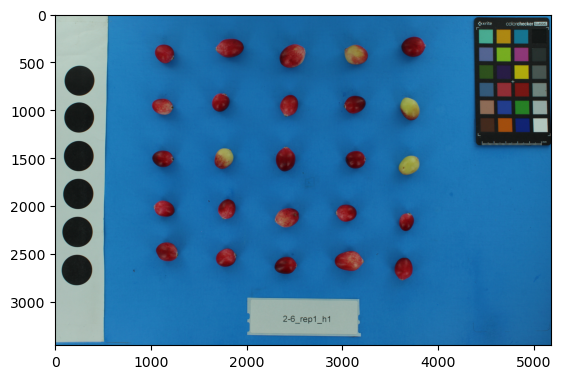

In [2]:
# load in the image and view it
img = cv2.imread('sample_images/demo_pipeline_image.jpg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

# note - the color conversion is just because OpenCV uses non-standard BGR colorspace
# matplotlib uses the standard RGB

In [3]:
# load the model structure and weights of the trained YOLO model
model = YOLO('best.pt')

In [4]:
# applying the model is simple
# by default, the script will apply the model at full resolution
result = model.predict(img, imgsz=img.shape[0:2])[0]

# you can run at a lower resolution to save time
# but be aware that the output contours will accordingly be blockier
lowres = model.predict(img, imgsz=2560)


0: 3456x5184 2 color_cards, 25 cranberrys, 6 sizemarker_blacks, 4224.0ms
Speed: 64.2ms preprocess, 4224.0ms inference, 866.4ms postprocess per image at shape (1, 3, 3456, 5184)

0: 1728x2560 1 color_card, 25 cranberrys, 6 sizemarker_blacks, 1021.3ms
Speed: 21.6ms preprocess, 1021.3ms inference, 56.4ms postprocess per image at shape (1, 3, 1728, 2560)


In [5]:
# the names of the classes to be detected are contained within the output
print('class names:\n%s' % result.names)

# each box thus has a class associated with it
print('\nclass values:\n%s' % result.boxes.cls)

# each box also has a confidence score
print('\nconfidence scores:\n%s' % result.boxes.conf)

class names:
{0: 'color_card', 1: 'cranberry', 2: 'info', 3: 'sizemarker_black'}

class values:
tensor([3., 1., 1., 1., 1., 1., 1., 3., 1., 3., 1., 1., 1., 1., 1., 1., 1., 1., 3., 1., 1., 3., 1., 1., 1., 1., 3., 1., 1., 1., 1., 0., 0.])

confidence scores:
tensor([0.9797, 0.9776, 0.9757, 0.9752, 0.9746, 0.9746, 0.9733, 0.9733, 0.9706, 0.9700, 0.9689, 0.9670, 0.9665, 0.9664, 0.9664, 0.9656, 0.9650, 0.9641, 0.9636, 0.9633, 0.9622, 0.9621, 0.9619, 0.9619, 0.9616, 0.9585, 0.9580, 0.9566, 0.9470, 0.9433, 0.9376, 0.9315, 0.3203])


In [7]:
# pulling the XY coordinates of the bounding boxes is simple
# to avoid false positives, we set a minimum confidence score
# this cutoff is drawn from the results of model training
min_conf = 0.897
cran_xy = [x for i,x in enumerate(result.masks.xy) if result.boxes.conf[i] > min_conf and result.boxes.cls[i] == 1.]

# a bit of conversion so the coordinates are in the right format for OpenCV contours
berry_contours = [np.expand_dims(x.astype(np.int32), axis=1) for x in cran_xy]

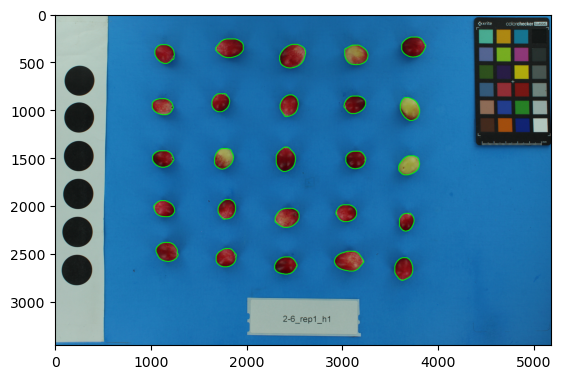

In [8]:
# visualize the contours
annot = img.copy()
cv2.drawContours(annot, berry_contours, -1, (0,255,0), 8)
plt.imshow(cv2.cvtColor(annot, cv2.COLOR_BGR2RGB))

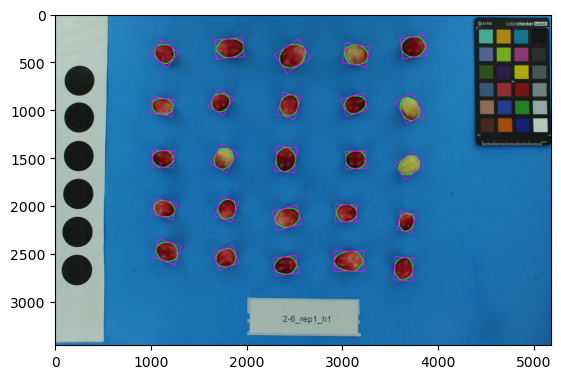

In [9]:
# length and width measurements are derived from the L/W of the oriented bounding box
obbs = [oriented_bounding_box(x) for x in berry_contours]
obbs_for_drawing = [np.intp(cv2.boxPoints(x)) for x in obbs]
cv2.drawContours(annot, obbs_for_drawing, -1, (255,0,255), 8)
plt.imshow(cv2.cvtColor(annot, cv2.COLOR_BGR2RGB))

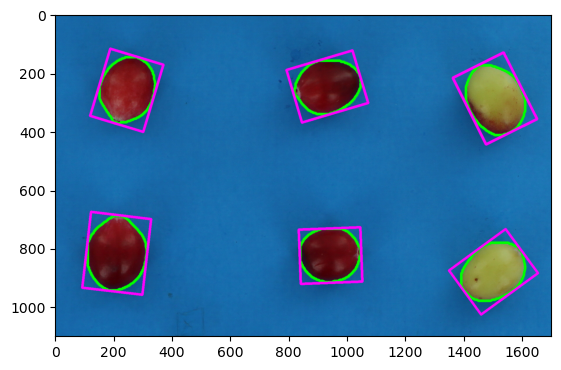

In [10]:
# it's a little hard to see on Jupyter, so let's zoom in a bit
plt.imshow(cv2.cvtColor(annot, cv2.COLOR_BGR2RGB)[700:1800,2200:3900,:])

# from the bounding box and the segmentation profile,
# we calculate or estimate the other size and shape metrics
# see the publication (Loarca et al. 2024) for more details

Initial mean DeltaE:  12.4579264344


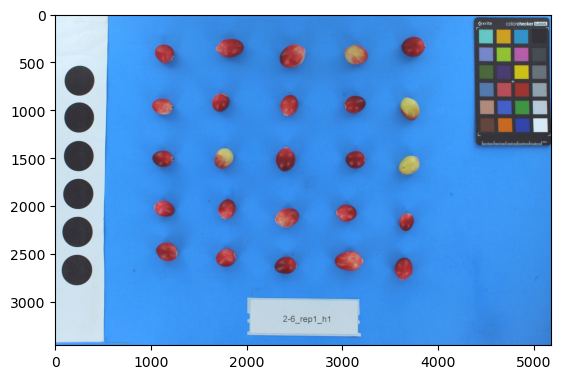

In [11]:
# often we want to compare color across multiple imaging runs
# we can apply a color correction step to try and account for variations in lighting etc
cc = ColorCorrectionML(img)
cc.compute_correction(method='linear')
corrected = cc.correct_img(img)

plt.imshow(cv2.cvtColor(corrected, cv2.COLOR_BGR2RGB))

# IMPORTANT - color correction is complex even under ideal circumstances
# ideally you have images in RAW format with standard illuminants, but this is often not the case
# if lighting or backgrounds vary between images,
# interpret any corrected or uncorrected color results very cautiously

In [12]:
# oftentimes berries will be organized into rows and columns
# we can use K means clustering to assign row/col to objects in the output
# the script sorts things row-wise first, then by column within row

# the centerpoints are taken from the oriented bounding boxes
cran_centerpoints_y = np.array([int(obb[0][1]) for obb in obbs])
# reshape it, since we are skipping over some steps from the script
cran_centerpoints_y = np.expand_dims(cran_centerpoints_y, 1)

# fxn will look for value of k with highest proportional drop in inertia/error
# this represents the most plausible value for number of rows
best_clust = k_means_unknown_k(cran_centerpoints_y)
print('n clusters: %s' % best_clust.n_clusters)

n clusters: 5


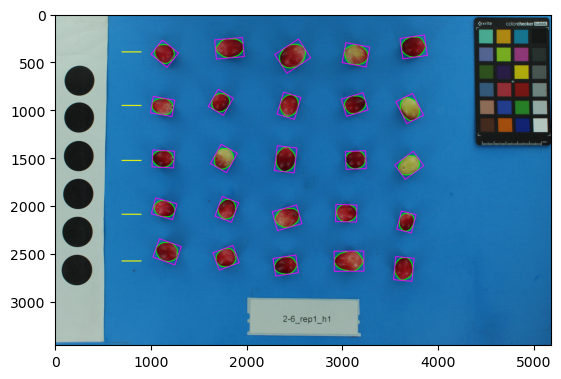

In [19]:
# these row positions aren't visualized in the script output
# but we can draw them here for illustration purposes
for y in best_clust.cluster_centers_[:,0]:
    cv2.line(annot, (700,int(y)),( 900,int(y)),(0,255,255),10)

plt.imshow(cv2.cvtColor(annot, cv2.COLOR_BGR2RGB))

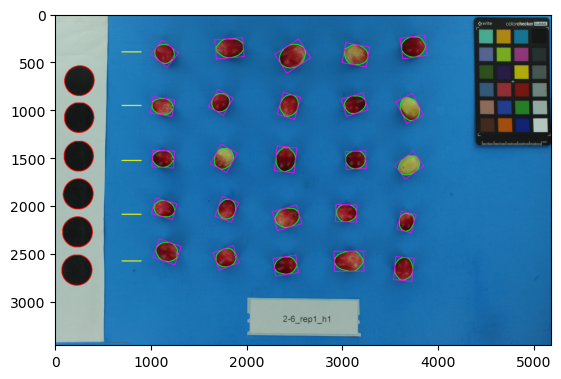

In [23]:
# unless you have size markers to calibrate to real units, the output will just be in pixels
# that's better than nothing, but not ideal for most purposes

# the model has been trained to recognize black circular size markers
# segmentation contours are extracted for these in the same way as for cranberries above
min_conf = 0.897
marker_xy = [x for i,x in enumerate(result.masks.xy) if result.boxes.conf[i] > min_conf and result.boxes.cls[i] == 3.]
marker_contours = [np.expand_dims(x.astype(np.int32), axis=1) for x in marker_xy]

# they are outlined in the annotated output from the script
# so you can verify that detection and segmentation worked well
cv2.drawContours(annot, marker_contours, -1, (0,0,255), 8)
plt.imshow(cv2.cvtColor(annot, cv2.COLOR_BGR2RGB))
